## <b>01<span style='color:#e61427'>|</span> Importing Libraries </b>

In [53]:
# Importing necessary libraries for deep learning, image processing, and data handling

import os  # Interact with the operating system (file and directory manipulation)
import shutil  # High-level file operations like copying, moving, and removing
import itertools  # Tools for efficient looping and combinatorics
import pathlib  # For working with file and directory paths
from collections import Counter  # Utility for counting elements in an iterable
import hashlib

import numpy as np  # Array manipulation and mathematical operations
import pandas as pd  # Data manipulation and analysis using dataframes
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # Enhanced data visualization (built on top of Matplotlib)
sns.set(style='darkgrid')  # Set Seaborn's default theme for plots

from PIL import Image  # Open, manipulate, and save images
import cv2  # OpenCV for advanced image processing

import torch  # Main PyTorch library for tensor operations
import torch.nn as nn  # Provides modules for defining neural network layers
import torch.optim as optim  # Optimizers for model training (e.g., SGD, Adam)
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Reduce learning rate when a metric plateaus
import torch.nn.functional as F  # Importing PyTorch's functional API, aliased as 'F'

import torchvision  # Core library for image-based models and datasets
import torchvision.transforms as transforms  # Image transformations (e.g., resizing, normalizing)

from torchsummary import summary  # Display a summary of the neural network architecture
import splitfolders  # Split image dataset folders into train, validation, and test sets

from tqdm.notebook import tqdm  # Progress bars for loops and tracking long-running tasks

from sklearn.metrics import confusion_matrix, classification_report  # Generate evaluation metrics like confusion matrix and classification report

# Libraries for explainability methods (model interpretation)
import shap  # SHAP values for model interpretability
from lime import lime_image  # LIME for image explanation
from skimage.segmentation import mark_boundaries  # Segmentation utility for marking boundaries in image explanations

# Captum library for model interpretability in PyTorch
from captum.attr import IntegratedGradients, Occlusion  # Attribution methods from Captum

# Visualization tools for explainability
import matplotlib.patches as mpatches  # Drawing shapes on visualizations



In [54]:
# New dataset path
data_dir = 'Dataset/Working data'
data_dir = pathlib.Path(data_dir)

In [55]:
# Define the root folder to count files in
folder_to_process = 'Dataset/Working data'

# Traverse the directory structure and count files in each subdirectory
for root, dirs, files in os.walk(folder_to_process):
    # Only print the count for directories (subdirectories)
    if len(files) > 0:
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}\n")


Directory: Dataset/Working data\train\Brain Tumor
Number of files: 1560

Directory: Dataset/Working data\train\Healthy
Number of files: 1199

Directory: Dataset/Working data\val\Brain Tumor
Number of files: 669

Directory: Dataset/Working data\val\Healthy
Number of files: 515



#### <b><span style='color:#e61227'>|</span> Image Transformation </b>

In [56]:
# Define a set of transformations for image preprocessing
transform = transforms.Compose([
    # Resize the image to 256x256 pixels
    transforms.Resize((256, 256)),
    
    # Apply random horizontal flip with a probability of 50%
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Apply random vertical flip with a probability of 50%
    transforms.RandomVerticalFlip(p=0.5),
    
    # Apply random rotation within a range of -30 to +30 degrees
    transforms.RandomRotation(30),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize the image using the mean and standard deviation values for each channel (RGB)
    # These values are commonly used for pre-trained models like ResNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [57]:
# Define the training dataset using the ImageFolder class from torchvision. 
# 'data_dir.joinpath("train")' points to the directory containing training images. 
# The 'transform' argument is applied to preprocess the images (e.g., resizing, normalization).
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)

# Accessing and verifying the transformations applied to the training dataset. 
# This could be useful for debugging or logging purposes.
train_set.transform

# Define the validation (test) dataset using the ImageFolder class.
# 'data_dir.joinpath("val")' points to the directory containing validation images.
# The same 'transform' argument is applied for consistency in image preprocessing.
test_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)

# Accessing and verifying the transformations applied to the validation dataset.
test_set.transform


Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## <b>03<span style='color:#e61227'>|</span> Model Development and Evaluation - Baseline Model </b>

#### <b><span style='color:#e61227'>|</span> Creating Dataloaders </b>

In [58]:
# Define the batch size for training and validation.
# This means the model will process 120 images at a time before updating the weights.
batch_size = 256

# Define the number of epochs for training.
# The model will go through the entire dataset 20 times during training.
num_epochs = 40

# Determine the device for computation.
# If a CUDA-enabled GPU is available, the code will use it for faster computations.
# Otherwise, it will default to using the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [59]:
# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_set,                # The dataset to load (training data)
    batch_size=batch_size,    # Number of samples to process at once (batch size)
    shuffle=True,             # Shuffle the dataset at every epoch to reduce overfitting and improve generalization
    num_workers=2             # Number of subprocesses to use for data loading; using 2 workers can speed up data loading
)

# Create a DataLoader for the validation (test) dataset
test_loader = torch.utils.data.DataLoader(
    test_set,                  # The dataset to load (validation data)
    batch_size=batch_size,     # Number of samples to process at once (batch size)
    shuffle=True,              # Shuffle the validation data; while not strictly necessary, it can provide robustness in validation performance evaluation
    num_workers=2              # Number of subprocesses to use for data loading to improve loading speed
)



In [60]:
# Print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "test data": test_loader}.items():
    # Iterate over a dictionary containing the DataLoaders for training and validation sets
    for X, y in value:
        # Get the first batch of data from the DataLoader
        print(f"{key}:")  # Print the key ('Training data' or 'test data')
        print(f"Shape of X : {X.shape}")  # Print the shape of the input data (features X)
        print(f"Shape of y: {y.shape} {y.dtype}\n")  # Print the shape and data type of the labels (y)
        break  # Break after printing the shape for the first batch only


Training data:
Shape of X : torch.Size([256, 3, 256, 256])
Shape of y: torch.Size([256]) torch.int64

test data:
Shape of X : torch.Size([256, 3, 256, 256])
Shape of y: torch.Size([256]) torch.int64



#### <b><span style='color:#e61227'>|</span> Define Output Feature Map for Convolution layer</b>

In [61]:
def findConv2dOutShape(hin, win, conv, pool=2,stride =2, padding=2):
    # Define a function to compute the output height and width of a 2D convolutional layer
    # hin: Input height
    # win: Input width
    # conv: Convolutional layer object (e.g., nn.Conv2d)
    # pool: Pooling size (default is 2, which is typical for max pooling)

    # Get convolutional layer parameters
    kernel_size = conv.kernel_size  # Size of the convolutional filter (e.g., (3, 3))
    stride = conv.stride            # Stride of the convolution (e.g., (2, 2))
    padding = conv.padding          # Padding applied to the input (e.g., (2, 2))
    dilation = conv.dilation        # Dilation of the convolution (spacing between kernel elements)

    # Calculate the output height after convolution
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    # Formula breakdown:
    # hin: Input height
    # + 2 * padding[0]: Add padding on top and bottom
    # - dilation[0] * (kernel_size[0] - 1): Account for dilation
    # - 1: Adjust for the filter's effect
    # / stride[0]: Divide by the stride to get the number of strides taken
    # + 1: Include the starting position in the count

    # Calculate the output width after convolution
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
    # Formula breakdown: Similar to height calculation but for width

    # If a pooling layer follows, adjust the output dimensions
    if pool:
        hout /= pool  # Divide output height by pooling size
        wout /= pool  # Divide output width by pooling size

    # Return the computed output dimensions as integers
    return int(hout), int(wout)


#### <b><span style='color:#e61227'>|</span> Define Architecture For CNN Model</b>

In [62]:
import torch.nn.functional as F
import torch.nn as nn

# Define Architecture For CNN_BT Model
class CNN_BT(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        # Call the constructor of the parent class nn.Module
        super(CNN_BT, self).__init__()
        
        # Extract parameters from the input dictionary
        Cin, Hin, Win = params["shape_in"]  # Input channels, height, and width of the input image
        init_f = params["initial_filters"]   # Initial number of filters for the first convolution layer
        num_fc1 = params["num_fc1"]          # Number of units in the first fully connected layer
        num_classes = params["num_classes"]   # Number of output classes for classification
        self.dropout_rate = params["dropout_rate"]  # Dropout rate for regularization
        
        # Convolution Layers
        # Define the first convolutional layer with 3x3 kernel
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=5,stride =2, padding=2)
        # Calculate the output height and width after conv1
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=5,stride =2, padding=2)
        # Calculate the output height and width after conv2
        h, w = findConv2dOutShape(h, w, self.conv2)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=5,stride =2, padding=2)
        # Calculate the output height and width after conv3
        h, w = findConv2dOutShape(h, w, self.conv3)
        
        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=5,stride =2, padding=2)
        # Calculate the output height and width after conv4
        h, w = findConv2dOutShape(h, w, self.conv4)
        
        # Compute the size of the flattened layer after convolutions
        self.num_flatten = h * w * 8 * init_f  # This will be the input size for the first fully connected layer
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)  # First fully connected layer
        self.fc2 = nn.Linear(num_fc1, num_classes)  # Second fully connected layer (output layer)

    def forward(self, X):
        # Forward pass through the network
        # Apply ReLU activation and average pooling after each convolution
        X = F.relu(self.conv1(X))  # Apply conv1 and ReLU activation
        X = F.avg_pool2d(X, 2, 2)  # Apply average pooling with a 2x2 window and a stride of 2
        
        X = F.relu(self.conv2(X))  # Apply conv2 and ReLU activation
        X = F.avg_pool2d(X, 2, 2)  # Apply average pooling with a 2x2 window and a stride of 2
        
        X = F.relu(self.conv3(X))  # Apply conv3 and ReLU activation
        X = F.avg_pool2d(X, 2, 2)  # Apply average pooling with a 2x2 window and a stride of 2
        
        X = F.relu(self.conv4(X))  # Apply conv4 and ReLU activation
        X = F.avg_pool2d(X, 2, 2)  # Apply average pooling with a 2x2 window and a stride of 2
        

        # Flatten the output for the fully connected layers
        X = X.view(-1, self.num_flatten)  # Reshape to (batch_size, num_flatten)
        
        X = F.relu(self.fc1(X))  # Apply the first fully connected layer and ReLU activation
        X = F.dropout(X, self.dropout_rate)  # Apply dropout for regularization
        
        X = self.fc2(X)  # Apply the second fully connected layer (output layer)
        
        # Return the output probabilities after applying softmax
        return F.log_softmax(X, dim=1)  # Logarithm of softmax for numerical stability


#### <b><span style='color:#e61227'>|</span> Define a dictionary containing parameters for the CNN model</b>

In [63]:
# Define a dictionary containing parameters for the CNN model
params = {
    "shape_in": (3, 256, 256),  # Input shape: 3 channels (RGB), height = 256, width = 256
    "initial_filters": 8,        # Number of filters in the first convolutional layer
    "num_fc1": 300,              # Number of neurons in the first fully connected layer
    "dropout_rate": 0.4,        # Dropout rate for regularization to prevent overfitting
    "num_classes": 2              # Number of output classes for classification (e.g., healthy and tumor)
}

#### <b><span style='color:#e61227'>|</span> Create an instance of the CNN model</b>

In [64]:
# Create an instance of the CNN_TUMOR class with the specified parameters
cnn_model = CNN_BT(params)

# Move the CNN model to the specified device (GPU or CPU)
model = cnn_model.to(device)
# This line transfers the model's parameters and buffers to the specified device, allowing it to utilize the GPU for faster computation if available.

#### <b><span style='color:#e61227'>|</span> Model Summary</b>

In [65]:
model_summary = summary(cnn_model, input_size=(3, 256, 256), device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            608
├─Conv2d: 1-2                            3,216
├─Conv2d: 1-3                            12,832
├─Conv2d: 1-4                            51,264
├─Linear: 1-5                            19,500
├─Linear: 1-6                            602
Total params: 88,022
Trainable params: 88,022
Non-trainable params: 0


In [66]:
# Model Summary
print(cnn_model)

CNN_BT(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=64, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)


#### <b><span style='color:#e61227'>|</span> Loss Function Definition  </b>

In [67]:
criterion = nn.CrossEntropyLoss()

In [68]:
# Create an Adam optimizer for the CNN model parameters with a learning rate of 0.0003 (3e-4)
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)


# Initialize a learning rate scheduler without the verbose parameter
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=1)


#### <b><span style='color:#e61227'>|</span> Loss and Metric </b>

In [69]:
# Initialize empty lists to store the loss values during training and testing
train_losses, test_losses = [], []  # `train_losses` will store the loss for each training epoch, and `test_losses` will store the loss for each testing/validation epoch

# Initialize empty lists to store accuracy values for training and testing
train_accs, test_accs = [], []  # `train_accs` will store the accuracy for each training epoch, and `test_accs` will store the accuracy for each testing/validation epoch

# Initialize an empty list to store all predicted values during testing
all_preds = []  # This list will hold all predictions made by the model during testing, useful for later evaluation (e.g., confusion matrix, precision, recall)

# Initialize an empty list to store all target values during testing
all_targets = []  # This list will hold all true target values (ground truth labels) during testing, used for comparison with `all_preds` to calculate evaluation metrics


#### <b><span style='color:#e61227'>|</span> Training Function </b>

In [70]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model in training mode (this enables certain layers like dropout to behave accordingly)
    model.train()
    
    correct = 0  # Variable to count how many predictions were correct
    total_loss = 0  # Variable to accumulate the total loss over the training epoch
    
    # Use tqdm to create a progress bar for the training loop
    # `tqdm(train_loader)` creates a progress bar, showing the progress of batches during training
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch}/{num_epochs} - Training") as tepoch:
        for data, target in tepoch:
            # Move data and targets to the specified device (GPU or CPU)
            data, target = data.to(device), target.to(device)
            
            # Zero the gradients to prevent accumulation from previous steps
            optimizer.zero_grad()
            
            # Forward pass: Compute the model's output for the current batch
            output = model(data)
            
            # Calculate the cross-entropy loss between the model's predictions and the true labels
            loss = criterion(output, target)
            
            # Backward pass: Compute gradients of the loss with respect to model parameters
            loss.backward()
            
            # Perform one optimization step (update the model's weights)
            optimizer.step()
            
            # Accumulate the loss over all batches in the epoch
            total_loss += loss.item()
            
            # Get the predicted class (with the highest score)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Compare the predicted class to the actual class and count correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Update the progress bar description with the current loss value
            tepoch.set_postfix(loss=loss.item())
    
    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(train_loader.dataset)
    
    # Calculate the accuracy for the epoch
    acc = 100. * correct / len(train_loader.dataset)
    
    # Append the average loss and accuracy for the current epoch to the respective tracking lists
    train_losses.append(avg_loss)
    train_accs.append(acc)
    
    # Print the summary of the training epoch
    print(f"\nTrain Epoch {epoch} - Average Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%\n")


#### <b><span style='color:#e61227'>|</span> Testing Function </b>

In [71]:
def test(model, device, test_loader):
    # Set the model to evaluation mode
    model.eval()  # This disables dropout and batch normalization layers, which behave differently during evaluation

    test_loss = 0  # Variable to accumulate the total loss over the test set
    correct = 0  # Variable to count the correct predictions

    # Disable gradient computation for testing to save memory and computation
    with torch.no_grad():
        # Iterate through the test data loader
        for data, target in test_loader:
            # Move data and target labels to the specified device (CPU or GPU)
            data, target = data.to(device), target.to(device)
            
            # Forward pass: Compute the model's output for the current batch
            output = model(data)
            
            # Accumulate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Get the predicted class (the index of the maximum logit)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Compare the predictions to the true labels and count the correct ones
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Store predictions and targets for later evaluation (useful for metrics like confusion matrix)
            all_preds.extend(pred.cpu().numpy())  # Convert predictions to NumPy and store them
            all_targets.extend(target.cpu().numpy())  # Convert target labels to NumPy and store them

    # Calculate the average loss for the test set
    avg_loss = test_loss / len(test_loader.dataset)
    
    # Calculate the accuracy as a percentage
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Append the average loss and accuracy to the tracking lists
    test_losses.append(avg_loss)
    test_accs.append(accuracy)

    # Print the summary of the test epoch
    print(f"\nTest Epoch - Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n")


#### <b><span style='color:#e61227'>|</span> Model Training </b>

In [72]:
# Training loop with progress bar and status update after each epoch
for epoch in range(1, num_epochs + 1):
    # Train and test the model for the current epoch
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
# After the loop, you can add the final average summary if needed
avg_train_loss = sum(train_losses) / len(train_losses)
avg_test_loss = sum(test_losses) / len(test_losses)
avg_train_acc = sum(train_accs) / len(train_accs)
avg_test_acc = sum(test_accs) / len(test_accs)

print(f"Training Complete")
print(f"Average Training Loss: {avg_train_loss:.4f}, Average Training Accuracy: {avg_train_acc:.2f}%")
print(f"Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_acc:.2f}%")


Epoch 1/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 1 - Average Loss: 0.0027, Accuracy: 54.08%


Test Epoch - Average Loss: 0.0029, Accuracy: 56.50%



Epoch 2/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 2 - Average Loss: 0.0027, Accuracy: 56.54%


Test Epoch - Average Loss: 0.0029, Accuracy: 56.50%



Epoch 3/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 3 - Average Loss: 0.0027, Accuracy: 56.54%


Test Epoch - Average Loss: 0.0029, Accuracy: 56.50%



Epoch 4/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 4 - Average Loss: 0.0027, Accuracy: 56.54%


Test Epoch - Average Loss: 0.0028, Accuracy: 56.50%



Epoch 5/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 5 - Average Loss: 0.0026, Accuracy: 58.03%


Test Epoch - Average Loss: 0.0027, Accuracy: 66.30%



Epoch 6/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 6 - Average Loss: 0.0025, Accuracy: 69.41%


Test Epoch - Average Loss: 0.0026, Accuracy: 70.44%



Epoch 7/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 7 - Average Loss: 0.0024, Accuracy: 70.79%


Test Epoch - Average Loss: 0.0025, Accuracy: 71.54%



Epoch 8/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 8 - Average Loss: 0.0023, Accuracy: 71.87%


Test Epoch - Average Loss: 0.0024, Accuracy: 71.71%



Epoch 9/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 9 - Average Loss: 0.0022, Accuracy: 73.98%


Test Epoch - Average Loss: 0.0022, Accuracy: 73.99%



Epoch 10/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 10 - Average Loss: 0.0021, Accuracy: 74.52%


Test Epoch - Average Loss: 0.0022, Accuracy: 74.24%



Epoch 11/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 11 - Average Loss: 0.0020, Accuracy: 75.75%


Test Epoch - Average Loss: 0.0022, Accuracy: 75.34%



Epoch 12/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 12 - Average Loss: 0.0020, Accuracy: 77.02%


Test Epoch - Average Loss: 0.0020, Accuracy: 75.08%



Epoch 13/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 13 - Average Loss: 0.0019, Accuracy: 77.35%


Test Epoch - Average Loss: 0.0025, Accuracy: 71.71%



Epoch 14/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 14 - Average Loss: 0.0019, Accuracy: 78.43%


Test Epoch - Average Loss: 0.0020, Accuracy: 77.03%



Epoch 15/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 15 - Average Loss: 0.0018, Accuracy: 79.67%


Test Epoch - Average Loss: 0.0021, Accuracy: 77.79%



Epoch 16/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 16 - Average Loss: 0.0017, Accuracy: 80.97%


Test Epoch - Average Loss: 0.0018, Accuracy: 79.81%



Epoch 17/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 17 - Average Loss: 0.0017, Accuracy: 80.97%


Test Epoch - Average Loss: 0.0019, Accuracy: 80.07%



Epoch 18/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 18 - Average Loss: 0.0016, Accuracy: 82.71%


Test Epoch - Average Loss: 0.0017, Accuracy: 82.60%



Epoch 19/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 19 - Average Loss: 0.0016, Accuracy: 82.78%


Test Epoch - Average Loss: 0.0017, Accuracy: 81.42%



Epoch 20/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 20 - Average Loss: 0.0015, Accuracy: 84.31%


Test Epoch - Average Loss: 0.0017, Accuracy: 83.53%



Epoch 21/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 21 - Average Loss: 0.0015, Accuracy: 84.27%


Test Epoch - Average Loss: 0.0016, Accuracy: 82.94%



Epoch 22/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 22 - Average Loss: 0.0015, Accuracy: 83.80%


Test Epoch - Average Loss: 0.0015, Accuracy: 84.97%



Epoch 23/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 23 - Average Loss: 0.0014, Accuracy: 86.12%


Test Epoch - Average Loss: 0.0014, Accuracy: 85.73%



Epoch 24/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 24 - Average Loss: 0.0014, Accuracy: 86.19%


Test Epoch - Average Loss: 0.0014, Accuracy: 85.73%



Epoch 25/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 25 - Average Loss: 0.0013, Accuracy: 86.70%


Test Epoch - Average Loss: 0.0015, Accuracy: 85.30%



Epoch 26/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 26 - Average Loss: 0.0013, Accuracy: 86.01%


Test Epoch - Average Loss: 0.0016, Accuracy: 84.63%



Epoch 27/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 27 - Average Loss: 0.0013, Accuracy: 87.31%


Test Epoch - Average Loss: 0.0014, Accuracy: 86.23%



Epoch 28/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 28 - Average Loss: 0.0012, Accuracy: 86.99%


Test Epoch - Average Loss: 0.0013, Accuracy: 87.50%



Epoch 29/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 29 - Average Loss: 0.0013, Accuracy: 86.84%


Test Epoch - Average Loss: 0.0014, Accuracy: 85.30%



Epoch 30/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 30 - Average Loss: 0.0013, Accuracy: 86.92%


Test Epoch - Average Loss: 0.0015, Accuracy: 85.14%



Epoch 31/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 31 - Average Loss: 0.0013, Accuracy: 87.28%


Test Epoch - Average Loss: 0.0013, Accuracy: 86.23%



Epoch 32/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 32 - Average Loss: 0.0012, Accuracy: 87.64%


Test Epoch - Average Loss: 0.0013, Accuracy: 86.49%



Epoch 33/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 33 - Average Loss: 0.0012, Accuracy: 88.73%


Test Epoch - Average Loss: 0.0012, Accuracy: 88.34%



Epoch 34/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 34 - Average Loss: 0.0012, Accuracy: 88.26%


Test Epoch - Average Loss: 0.0013, Accuracy: 85.56%



Epoch 35/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 35 - Average Loss: 0.0011, Accuracy: 88.62%


Test Epoch - Average Loss: 0.0012, Accuracy: 86.40%



Epoch 36/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 36 - Average Loss: 0.0011, Accuracy: 89.02%


Test Epoch - Average Loss: 0.0012, Accuracy: 88.68%



Epoch 37/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 37 - Average Loss: 0.0011, Accuracy: 88.87%


Test Epoch - Average Loss: 0.0012, Accuracy: 88.01%



Epoch 38/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 38 - Average Loss: 0.0011, Accuracy: 88.73%


Test Epoch - Average Loss: 0.0012, Accuracy: 88.26%



Epoch 39/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 39 - Average Loss: 0.0011, Accuracy: 89.20%


Test Epoch - Average Loss: 0.0012, Accuracy: 88.77%



Epoch 40/40 - Training:   0%|          | 0/11 [00:00<?, ?batch/s]


Train Epoch 40 - Average Loss: 0.0010, Accuracy: 90.87%


Test Epoch - Average Loss: 0.0011, Accuracy: 89.36%

Training Complete
Average Training Loss: 0.0017, Average Training Accuracy: 79.77%
Average Testing Loss: 0.0018, Average Testing Accuracy: 79.20%


#### <b><span style='color:#e61227'>|</span> Visualisation </b>

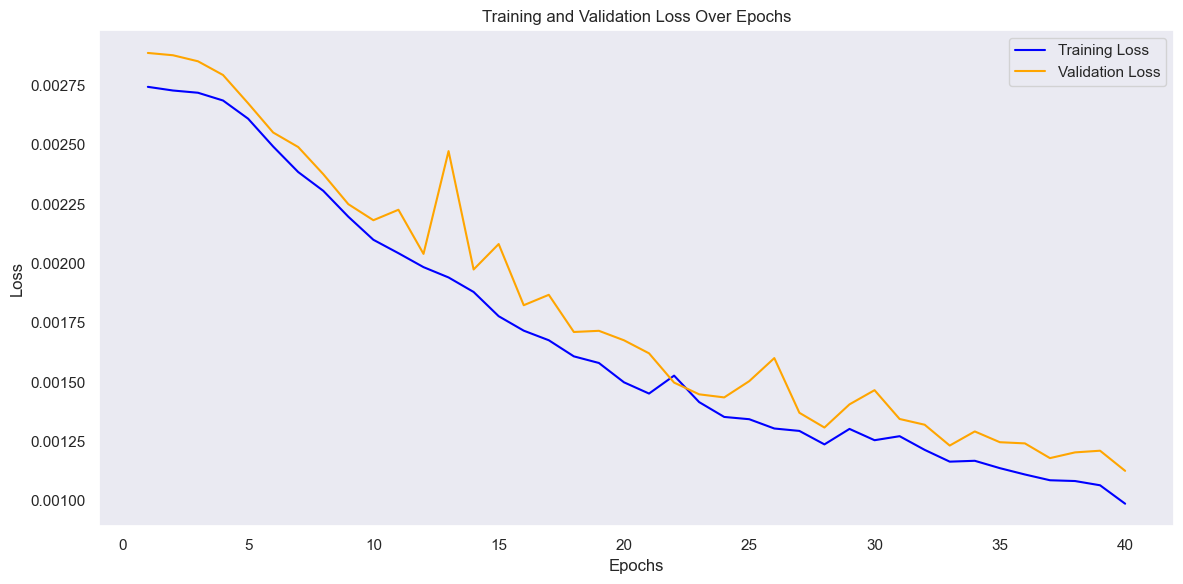

In [73]:
# Number of epochs from your parameters
epochs = num_epochs  # Use num_epochs instead of params_train["epochs"]

# Create a new figure for the plots
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')

# Plot validation (testing) loss
plt.plot(range(1, epochs + 1), test_losses, label='Validation Loss', color='orange')

# Add titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to distinguish between training and validation loss
plt.legend()

# Optionally add gridlines for better readability
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to make it look nice
plt.show()


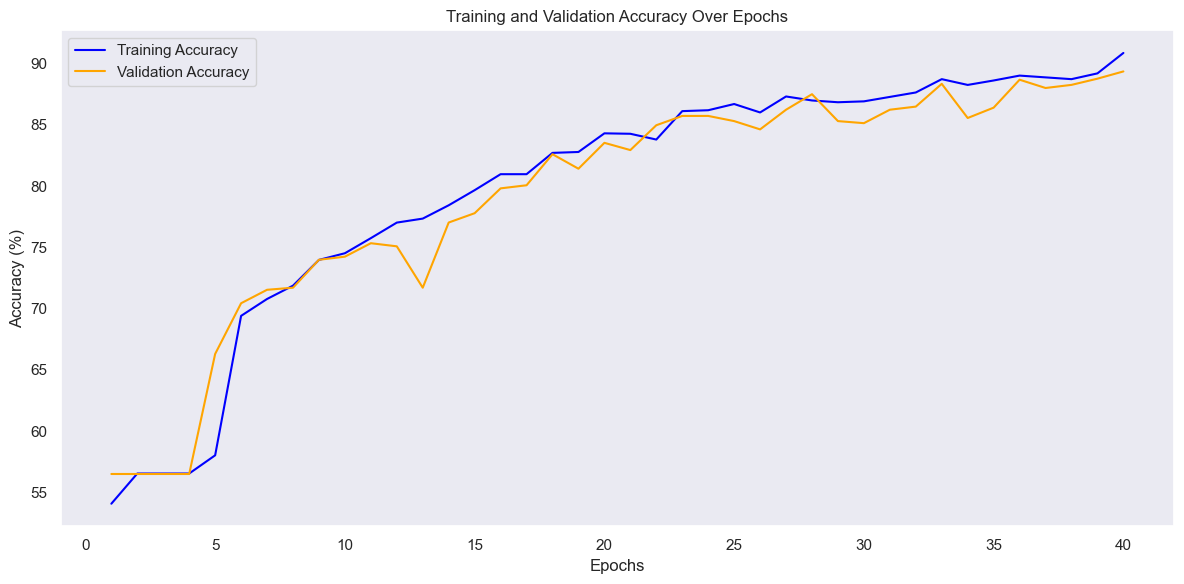

In [74]:
# Number of epochs from your parameters
epochs = num_epochs  # Use num_epochs instead of params_train["epochs"]

# Create a new figure for the accuracy plots
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy', color='blue')

# Plot validation (testing) accuracy
plt.plot(range(1, epochs + 1), test_accs, label='Validation Accuracy', color='orange')

# Add titles and labels
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

# Add a legend to distinguish between training and validation accuracy
plt.legend()

# Optionally add gridlines for better readability
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to make it look nice
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


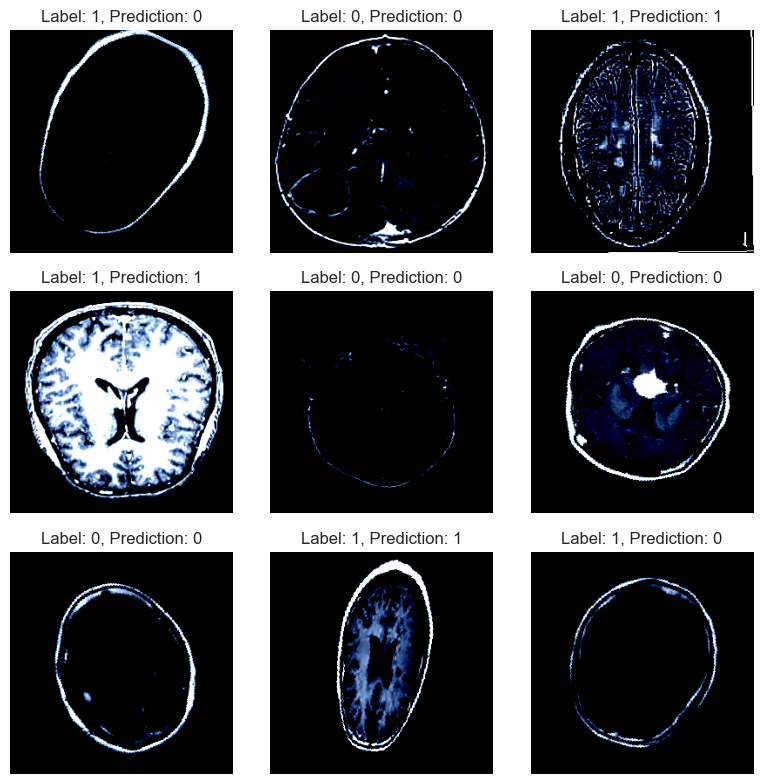

In [75]:
# Visualize some sample images and predictions
samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)

# Get model predictions
outputs = model(samples)
_, preds = torch.max(outputs, 1)

# Convert samples to numpy for visualization
samples = samples.cpu().numpy()

# Create a grid of 3x3 images for visualization
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    # Rearrange from (C, H, W) to (H, W, C) and denormalize the image
    img = samples[i].transpose((1, 2, 0))
    
    # Display the image
    ax.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
    
    # Set title with label and prediction
    ax.set_title(f'Label: {labels[i].item()}, Prediction: {preds[i].item()}')
    
    # Remove axes
    ax.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


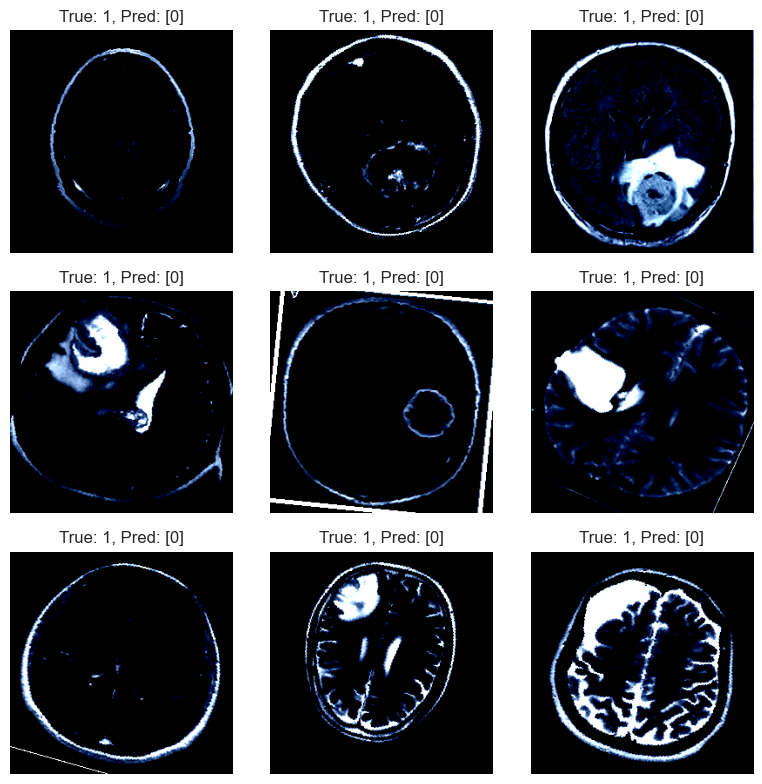

In [76]:
# Visualize incorrect predictions
# all_preds: list of predicted labels
# all_labels: list of actual labels

incorrect = [i for i in range(len(all_preds)) if all_preds[i] != all_targets[i]]

# Create a figure for displaying 3x3 grid of incorrect predictions
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through the first 9 incorrect predictions and plot them
for i, ax in enumerate(axes.ravel()):
    if i < len(incorrect):  # Make sure we don't exceed available incorrect samples
        idx = incorrect[i]
        
        # Get the image and its true and predicted labels
        image, _ = test_loader.dataset[idx]
        true_label = all_targets[idx]
        pred_label = all_preds[idx]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray' if image.shape[0] == 1 else None)
        
        # Set the title with true and predicted labels
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        
        # Remove the axis
        ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### <b><span style='color:#e61227'>|</span> Evaluation </b>

In [77]:
# Define function for obtaining true and predicted labels from the validation set
def Ture_and_Pred(test_loader, model):
    i = 0  # Initialize a counter (not used further)
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Loop through the validation DataLoader
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the appropriate device (GPU/CPU)
        labels = labels.numpy()  # Convert labels to a NumPy array for easier manipulation
        outputs = model(images)  # Get model predictions for the input images
        _, pred = torch.max(outputs.data, 1)  # Get the index of the maximum score (predicted class)
        pred = pred.detach().cpu().numpy()  # Move predictions to CPU and convert to NumPy array
        
        # Append the true labels and predicted labels to their respective lists
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred  # Return the lists of true and predicted labels


# Check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(test_loader, model)  # Get true and predicted labels using the function

# Print classification report to evaluate model performance
print(classification_report(y_true, y_pred), '\n\n')

# Calculate confusion matrix for further error analysis
cm = confusion_matrix(y_true, y_pred)  # Create the confusion matrix from true and predicted labels

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       669
         1.0       0.88      0.87      0.88       515

    accuracy                           0.89      1184
   macro avg       0.89      0.89      0.89      1184
weighted avg       0.89      0.89      0.89      1184
 




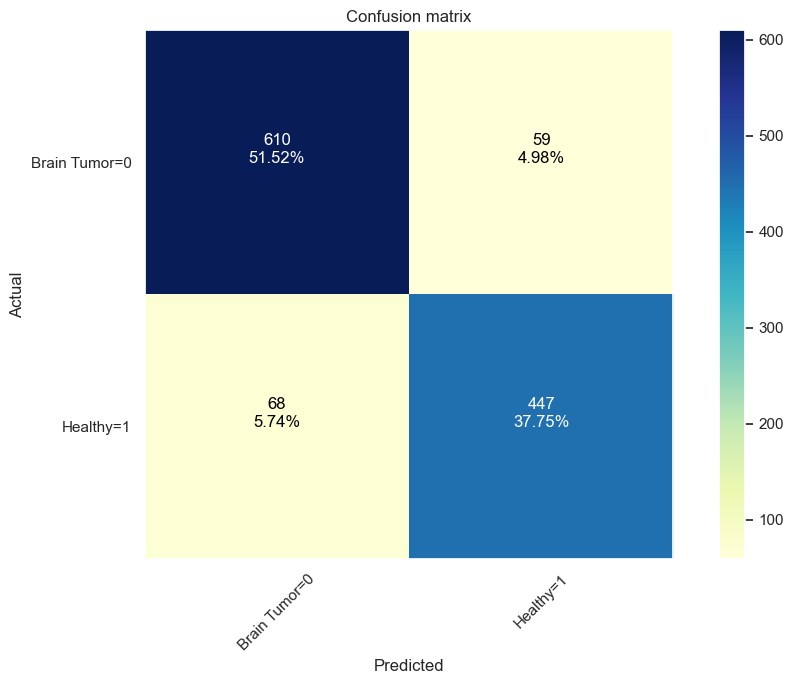

In [78]:
# Define the class labels
CLA_label = {
    0: 'Brain Tumor',
    1: 'Healthy'
}

# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    # Define a function to plot a confusion matrix
    # cm: confusion matrix
    # CLA_label: dictionary mapping class indices to class names
    # title: title of the plot
    # cmap: color map for the plot

    plt.figure(figsize=(10, 7))  # Create a new figure with a specified size (10x7 inches)
    plt.grid(False)  # Disable the grid for better visual clarity
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Display the confusion matrix as an image with the specified colormap
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a color bar to indicate the scale of values

    tick_marks = np.arange(len(CLA_label))  # Create an array of tick marks for the class labels
    # Set x-axis ticks and labels with class names, rotated 45 degrees for better readability
    plt.xticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()], rotation=45)
    # Set y-axis ticks and labels with class names
    plt.yticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()])

    thresh = cm.max() / 2.  # Determine the threshold for text color based on the maximum value in the confusion matrix
    # Iterate over each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Place text in each cell showing the number and percentage of predictions
        plt.text(j, i, f"{cm[i, j]}\n{cm[i, j] / np.sum(cm) * 100:.2f}%", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on the threshold

    plt.ylabel('Actual')  # Label for the y-axis
    plt.xlabel('Predicted')  # Label for the x-axis
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()  # Display the plot

# Call the function to show the confusion matrix
show_confusion_matrix(cm, CLA_label)


#### <b><span style='color:#e61227'>|</span> Save Model</b>

In [79]:
torch.save(cnn_model.state_dict(), 'model_cnn_c.pth')